# Análise de Series Temporais
- ### Aluno: Valdiclei Costa Marinho
- ### Aluno: Renan Lemes Leepkaln

## IPCA - Índice Nacional de Preços ao Consumidor Amplo

### Série histórica com número-índice, variação mensal e variações acumuladas

**Última atualização:** 2024-03-12 09:00:00

**Pesquisa:** Índice Nacional de Preços ao Consumidor Amplo

**Assunto:** Índices de preços

**Mês(531):** 197912-202402

#### IPCA - Número-índice (base: dezembro de 1993 = 100)

- **Número-índice (casas decimais):** padrão = 13, máximo = 13
- **Nível Territorial:** Brasil

**Nota:**
- Período de coleta ajustado ao mês civil (do primeiro ao trigésimo dia de cada mês), para os meses anteriores a março de 1986.

#### Atributos

- **NC - Nível Territorial (Código)**
- **NN - Nível Territorial**
- **MC - Unidade de Medida (Código)**
- **MN - Unidade de Medida**
- **V - Valor**
- **D1C - Brasil (Código)**
- **D1N - Brasil**
- **D2C - Variável (Código)**
- **D2N - Variável**
- **D3C - Mês (Código)**
- **D3N - Mês**

**Fonte:** [IBGE - Índice Nacional de Preços ao Consumidor Amplo](https://apisidra.ibge.gov.br)

In [82]:
# Bibliotecas
## Tratamento de dados
import pandas as pd
import numpy as np

## Stats
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Plots
import pmdarima as pmd
import matplotlib.pyplot as plt
import plotnine  as p9
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import warnings
warnings.filterwarnings("ignore")

### Coleta de dados

In [11]:
dados_brutos = pd.read_json(
    path_or_buf = ("https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/2266/p/all/d/" +"v2266%2013?formato=json")
)

In [12]:
# Deletando o cabeçalho
dados_brutos = dados_brutos.drop(index=0)

In [13]:
dados_brutos.head()

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
1,1,Brasil,30,Número-índice,0.0000000076183,1,Brasil,2266,IPCA - Número-índice (base: dezembro de 1993 =...,197912,dezembro 1979
2,1,Brasil,30,Número-índice,0.0000000081223,1,Brasil,2266,IPCA - Número-índice (base: dezembro de 1993 =...,198001,janeiro 1980
3,1,Brasil,30,Número-índice,0.0000000084973,1,Brasil,2266,IPCA - Número-índice (base: dezembro de 1993 =...,198002,fevereiro 1980
4,1,Brasil,30,Número-índice,0.0000000090104,1,Brasil,2266,IPCA - Número-índice (base: dezembro de 1993 =...,198003,março 1980
5,1,Brasil,30,Número-índice,0.0000000094867,1,Brasil,2266,IPCA - Número-índice (base: dezembro de 1993 =...,198004,abril 1980


In [14]:
dados_brutos.isna().sum().sort_index()/len(dados_brutos)

D1C    0.0
D1N    0.0
D2C    0.0
D2N    0.0
D3C    0.0
D3N    0.0
MC     0.0
MN     0.0
NC     0.0
NN     0.0
V      0.0
dtype: float64

In [15]:
dados_brutos.isnull().sum().sort_index()/len(dados_brutos)

D1C    0.0
D1N    0.0
D2C    0.0
D2N    0.0
D3C    0.0
D3N    0.0
MC     0.0
MN     0.0
NC     0.0
NN     0.0
V      0.0
dtype: float64

### Tratamento de dados

In [16]:
# Tratamento de dados
dados_tratados = (
  dados_brutos.rename(columns = {"V": "valor", "D3C": "data"}).query("valor != 'Valor'").assign
    (
      data = lambda x: pd.to_datetime(x.data, format = "%Y%m"),
      indice = lambda x: x.data,
      valor = lambda x: x.valor.astype(float)
    )
    .query("data >= '2014-01-01'")
    .set_index("indice")
    .filter(items = ["data", "valor"], axis = "columns")
    .asfreq("MS")
)

In [17]:
dados_tratados.head()

,data,valor
indice,,
2014-01-01,2014-01-01,3836.37
2014-02-01,2014-02-01,3862.84
2014-03-01,2014-03-01,3898.38
2014-04-01,2014-04-01,3924.50
2014-05-01,2014-05-01,3942.55


In [18]:
dados = (
    dados_tratados
    .assign(
        ipca = lambda x: (x.valor / x.valor.shift(1) - 1) * 100,
        ano = lambda x: x.data.dt.year,
        mes = lambda x: x.data.dt.month,
        trimestre = lambda x: x.data.dt.quarter,
        ipca_lag1 = lambda x: x.ipca.shift(1),
        tendencia = lambda x: range(-1, x.shape[0] - 1)
    )
   .dropna()  # Remove linhas com valores NaN gerados pela função LAG
)

In [19]:
dados.head()

,data,valor,ipca,ano,mes,trimestre,ipca_lag1,tendencia
indice,,,,,,,,
2014-03-01,2014-03-01,3898.38,0.920048,2014,3,1,0.689975,1
2014-04-01,2014-04-01,3924.50,0.670022,2014,4,2,0.920048,2
2014-05-01,2014-05-01,3942.55,0.459931,2014,5,2,0.670022,3
2014-06-01,2014-06-01,3958.32,0.399995,2014,6,2,0.459931,4
2014-07-01,2014-07-01,3958.72,0.010105,2014,7,3,0.399995,5


### Visualização do IPCA ao longo da série

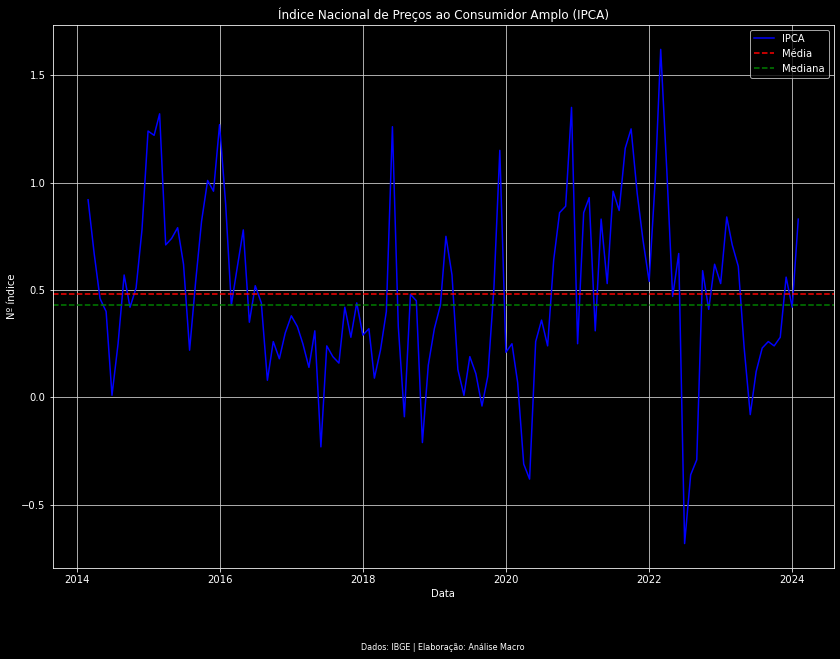

In [27]:
plt.figure(figsize=(14, 10))  # Definindo o tamanho da figura

# Plotando a linha da série temporal
plt.plot(dados.index, dados["ipca"], color="blue", label="IPCA")

# Adicionando linhas pontilhadas para a média e mediana do IPCA
plt.axhline(y=dados["ipca"].mean(), linestyle="--", color="red", label="Média")
plt.axhline(y=dados["ipca"].median(), linestyle="--", color="green", label="Mediana")

# Configurando os rótulos dos eixos e o título
plt.title("Índice Nacional de Preços ao Consumidor Amplo (IPCA)")
plt.xlabel("Data")
plt.ylabel("Nº índice")

# Adicionando legenda
plt.legend()

# Definindo o formato do eixo x para exibir a cada 2 anos
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=2))

# Exibindo a grade no plano de fundo
plt.grid(True, color="lightgrey")

# Adicionando uma anotação
plt.annotate(
    "Dados: IBGE | Elaboração: Análise Macro",
    xy=(0.5, -0.15),
    xycoords="axes fraction",
    ha="center",
    fontsize=8,
)

# Exibindo o gráfico
plt.show()

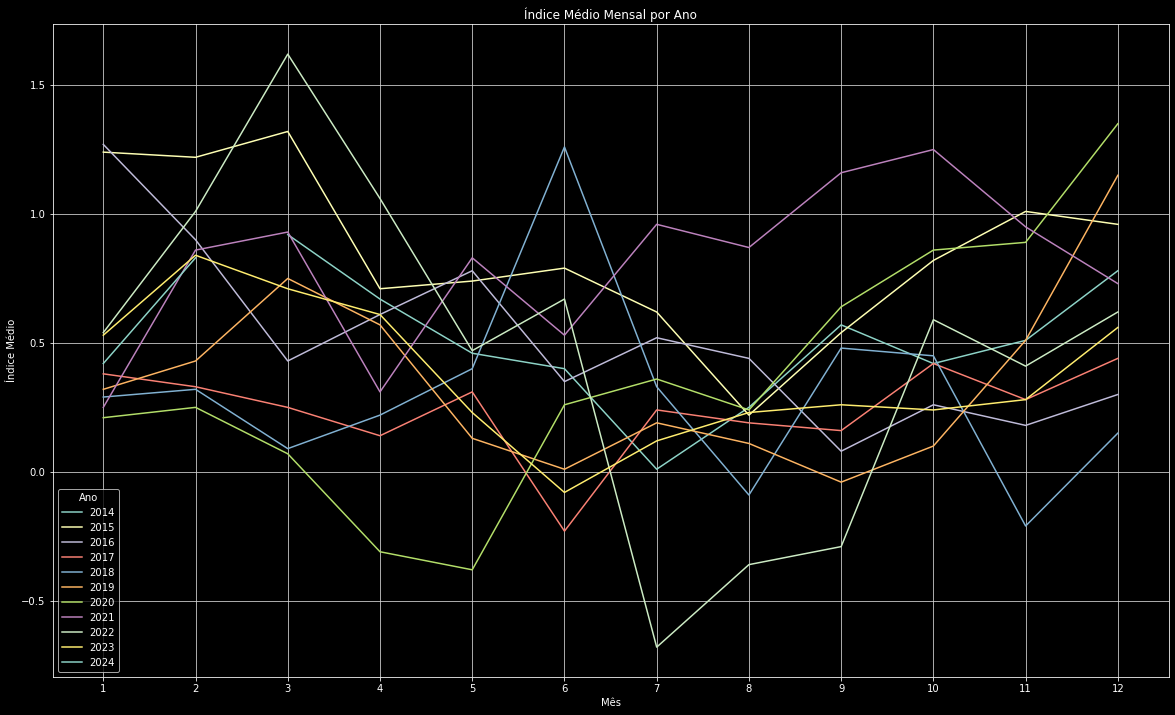

In [33]:
# Configuração do gráfico
plt.figure(figsize=(20, 12))  # Define o tamanho da figura

# Para cada ano, plota a linha da média mensal do IPCA
for ano, grupo in media_mensal_por_ano.groupby("ano"):
    plt.plot(grupo["mes"], grupo["ipca"], label=ano)

# Adiciona pontos de dados para cada mês
plt.scatter(media_mensal_por_ano["mes"], media_mensal_por_ano["ipca"], color="black")

# Adiciona título e rótulos dos eixos
plt.title("Índice Médio Mensal por Ano")
plt.xlabel("Mês")
plt.ylabel("Índice Médio")
plt.xticks(range(1, 13))  # Define os ticks do eixo x para representar os meses

# Adiciona legenda
plt.legend(title="Ano")

# Exibe o gráfico
plt.grid(True, color="lightgrey")  # Adiciona a grade no plano de fundo
plt.show()

### Validação de Estacionáriedade

#### Teste adfuller

In [35]:

serie_temporal = dados['ipca']

# Teste de Dickey-Fuller Aumentado (ADF)
resultado_adf = adfuller(serie_temporal)
print('Teste de Dickey-Fuller Aumentado (ADF):')
print('Estatística ADF:', resultado_adf[0])
print('Valor-p:', resultado_adf[1])
print('Valores críticos:')
for chave, valor in resultado_adf[4].items():
    print(f'   {chave}: {valor}')
if resultado_adf[1] < 0.05:
    print("Resultado: Série é estacionária (Rejeitamos a hipótese nula)")
else:
    print("Resultado: Série não é estacionária (Não rejeitamos a hipótese nula)")

Teste de Dickey-Fuller Aumentado (ADF):
Estatística ADF: -5.5809249815746345
Valor-p: 1.397238244397709e-06
Valores críticos:
   1%: -3.4865346059036564
   5%: -2.8861509858476264
   10%: -2.579896092790057
Resultado: Série é estacionária (Rejeitamos a hipótese nula)


#### Teste de KPSS

In [36]:
resultado_kpss = kpss(serie_temporal)
print('\nTeste de KPSS:')
print('Estatística KPSS:', resultado_kpss[0])
print('Valor-p:', resultado_kpss[1])
print('Valores críticos:')
for chave, valor in resultado_kpss[3].items():
    print(f'   {chave}: {valor}')
if resultado_kpss[1] > 0.05:
    print("Resultado: Série é estacionária (Rejeitamos a hipótese nula)")
else:
    print("Resultado: Série não é estacionária (Não rejeitamos a hipótese nula)")


Teste de KPSS:
Estatística KPSS: 0.14988631690915621
Valor-p: 0.1
Valores críticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Resultado: Série é estacionária (Rejeitamos a hipótese nula)


### Analisando Outliers

In [37]:
dados['ipca'].describe()

count    120.000000
mean       0.480334
std        0.408555
min       -0.680003
25%        0.237496
50%        0.429950
75%        0.757446
max        1.620050
Name: ipca, dtype: float64

In [38]:
print('Validação Outliers pelo método de IQR\n')
for i in dados[['ipca']]:
    Q1 = dados[i].quantile(0.25)
    Q3 = dados[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f'{i}: Lower: {lower_bound} e Upper: {upper_bound}')
    print(f'Total de registros dentro dos limites {len(dados[(dados[i] >= lower_bound) & (dados[i] <= upper_bound)])}')
    print('-----------------------------------------------------\n')

Validação Outliers pelo método de IQR

ipca: Lower: -0.542428947291676 e Upper: 1.5373716727564575
Total de registros dentro dos limites 118
-----------------------------------------------------



### Análise de tendência

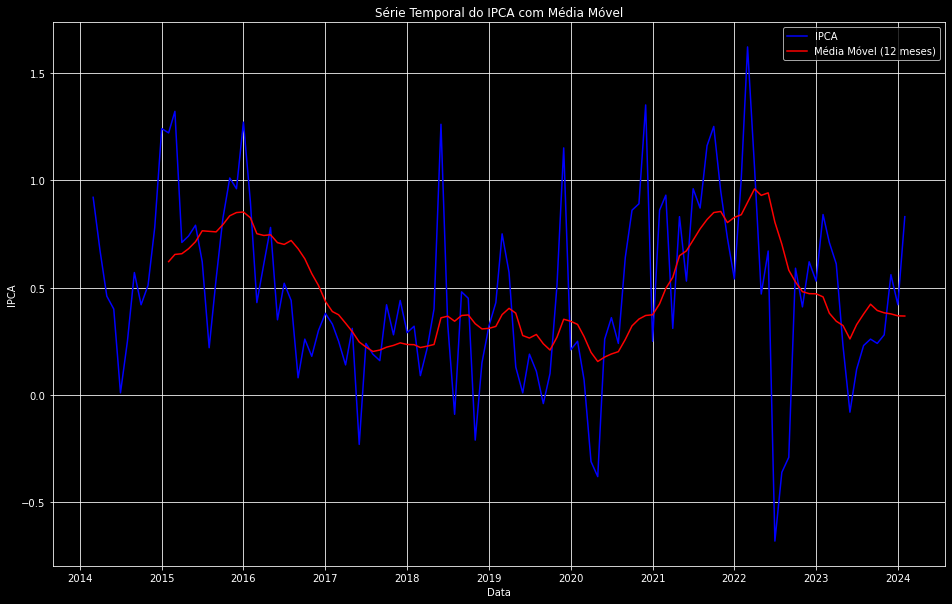

In [40]:
# Calcular a média móvel com janela de 12 meses
media_movel = dados['ipca'].rolling(window=12).mean()

# Plotar o gráfico de tendência suavizada
plt.figure(figsize=(16, 10))
plt.plot(dados.index, dados['ipca'], color='blue', label='IPCA')
plt.plot(media_movel.index, media_movel, color='red', label='Média Móvel (12 meses)')
plt.title('Série Temporal do IPCA com Média Móvel')
plt.xlabel('Data')
plt.ylabel('IPCA')
plt.legend()
plt.grid(True)
plt.show()

#### Decomposição da série temporal

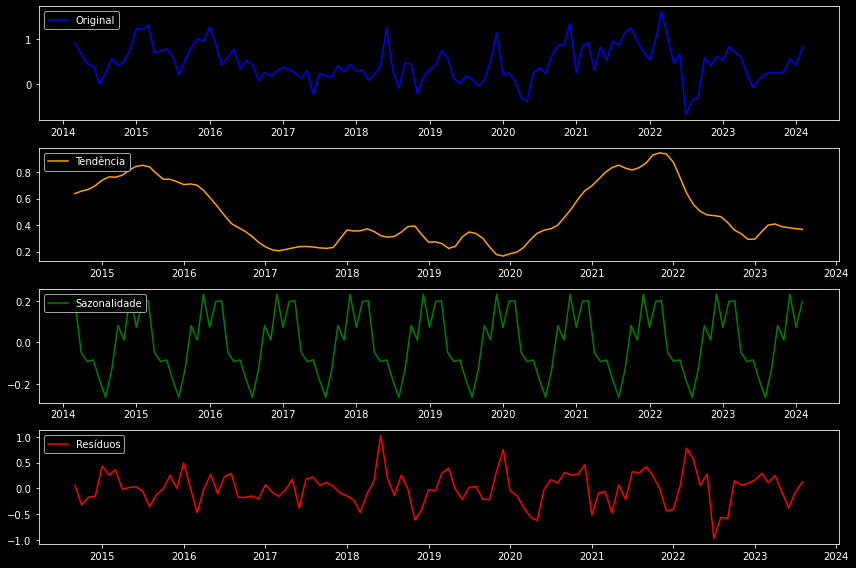

In [42]:
# Decomposição da série temporal
decomposition = seasonal_decompose(dados['ipca'], model='additive')

# Criando um novo DataFrame com os componentes da decomposição
decomposition_df = pd.DataFrame({
    'Tendência': decomposition.trend,
    'Sazonalidade': decomposition.seasonal,
    'Resíduos': decomposition.resid,
    'Data': dados.index  # Usando o índice do DataFrame original
})

# Definindo cores para cada componente
colors = ['blue', 'orange', 'green', 'red']

# Plotando os componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(dados.index, dados['ipca'], label='Original', color=colors[0])
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(dados.index, decomposition.trend, label='Tendência', color=colors[1])
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(dados.index, decomposition.seasonal, label='Sazonalidade', color=colors[2])
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(dados.index, decomposition.resid, label='Resíduos', color=colors[3])
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### Identificar registros com "divide by zero" ou "invalid value"

In [43]:
indices_divide_by_zero = dados['ipca'].isin([0])  # Valores que causam divisão por zero
indices_invalid_value = ~indices_divide_by_zero & dados['ipca'].isna()  # Outros valores inválidos

indices_problema = indices_divide_by_zero | indices_invalid_value
registros_problema = dados[indices_problema]
if registros_problema.count().sum() > 0:
    dados = dados.replace([np.inf, -np.inf], np.nan).dropna()    

### Verificação de Normalidade

#### Teste de Shapiro-Wilk: 
- valor

In [46]:
stat, p_value = shapiro(dados['ipca'].sort_index())

print("Estatística de teste:", stat)
print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("Não é possível rejeitar a hipótese nula - a distribuição parece ser normal.")
else:
    print("A hipótese nula é rejeitada - a distribuição não parece ser normal.")

Estatística de teste: 0.9871295094490051
Valor p: 0.31589242815971375
Não é possível rejeitar a hipótese nula - a distribuição parece ser normal.


### Covariância: 
- perc_ipca vs perc_ipca_lag1

O valor de correlação de 0.588 sugere que há uma relação linear positiva moderada entre as duas séries temporais.

In [47]:
correlation = dados['ipca'].corr(dados['ipca_lag1'])

print("Coeficiente de correlação entre as séries temporais ipca e ipca_lag1:", correlation)

Coeficiente de correlação entre as séries temporais ipca e ipca_lag1: 0.5835919579277595


In [48]:
covariance = dados['ipca'].cov(dados['ipca_lag1'])

print("Covariância entre as séries temporais ipca e ipca_lag1:", covariance)

Covariância entre as séries temporais ipca e ipca_lag1: 0.09721890076274677


Ao examinar o padrão sazonal no gráfico, torna-se evidente uma tendência de inflação mais baixa durante a metade do ano e maior no final ou início, embora ocorram algumas discrepâncias em anos específicos.

### Análise de Autocorrelação

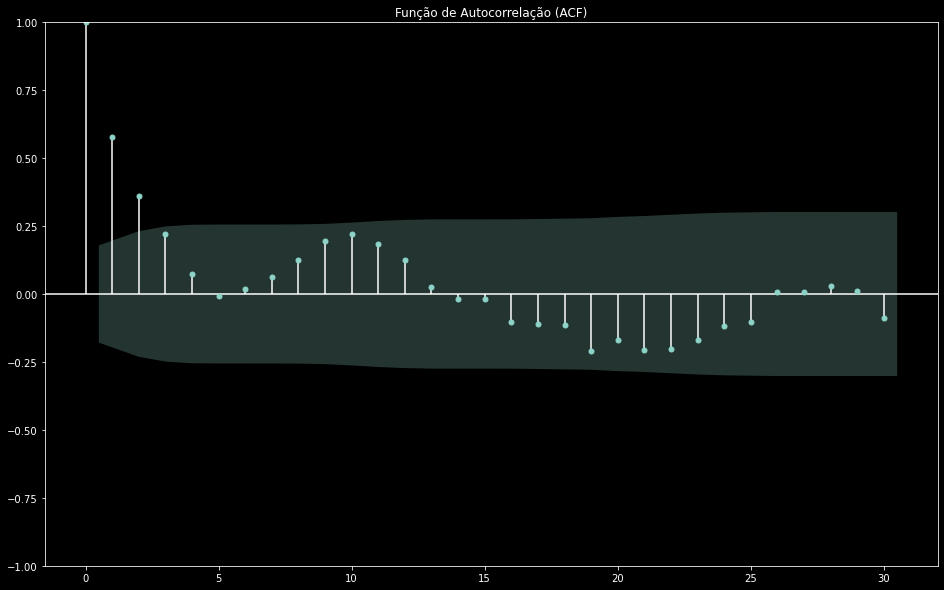

In [59]:
# Plot ACF
fig, ax = plt.subplots(figsize=(16, 10))
plot_acf(dados["ipca"], lags=30, ax=ax)
plt.title("Função de Autocorrelação (ACF)")
plt.show()

### Autocorrelação Parcial

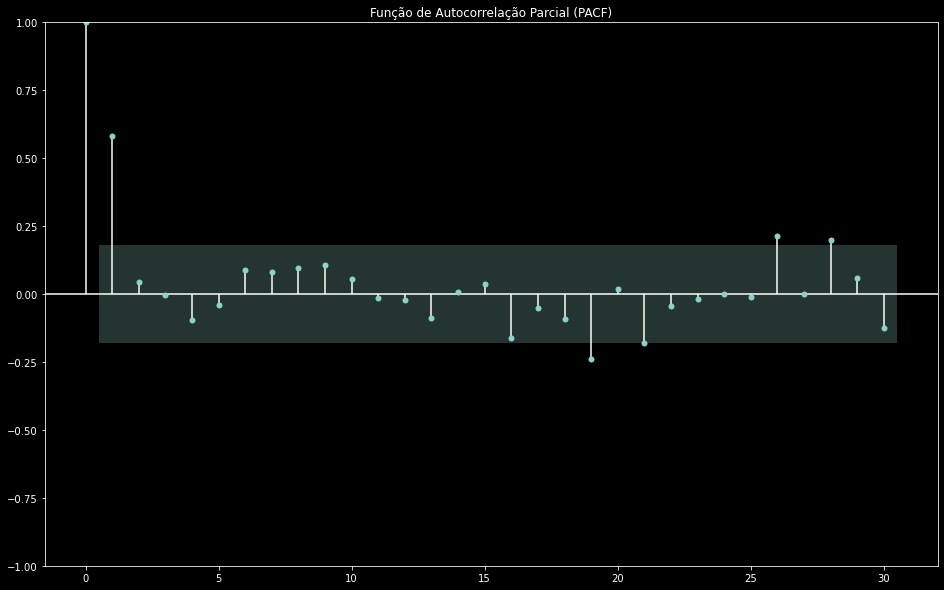

In [58]:
# Plot PACF
fig, ax = plt.subplots(figsize=(16, 10))

plot_pacf(dados['ipca'], lags=30, ax=ax)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

### Amostras de Teste e Treino

In [60]:
dados.tail(12)

,data,valor,ipca,ano,mes,trimestre,ipca_lag1,tendencia
indice,,,,,,,,
2023-03-01,2023-03-01,6609.67,0.710034,2023,3,1,0.839991,109
2023-04-01,2023-04-01,6649.99,0.610015,2023,4,2,0.710034,110
2023-05-01,2023-05-01,6665.28,0.229925,2023,5,2,0.610015,111
2023-06-01,2023-06-01,6659.95,-0.079967,2023,6,2,0.229925,112
2023-07-01,2023-07-01,6667.94,0.119971,2023,7,3,-0.079967,113
2023-08-01,2023-08-01,6683.28,0.230056,2023,8,3,0.119971,114
2023-09-01,2023-09-01,6700.66,0.260052,2023,9,3,0.230056,115
2023-10-01,2023-10-01,6716.74,0.239976,2023,10,4,0.260052,116
2023-11-01,2023-11-01,6735.55,0.280047,2023,11,4,0.239976,117


In [61]:
# Dados de teste
dados_teste = dados.tail(12).drop(["data", "valor"], axis = "columns")
y_teste = dados_teste.ipca
x_teste = dados_teste.drop("ipca", axis="columns")

# Dados de treino
dados_treino = dados.drop(y_teste.index).drop(["data", "valor"], axis="columns")
y_treino = dados_treino.ipca
x_treino = dados_treino.drop("ipca", axis="columns")

### Previsão ARIMA

In [62]:
# Estimar modelo
ajuste_arima = pmd.auto_arima(y = y_treino, seasonal = True, m = 12)

# Produzir previsões
previsao_arima = ajuste_arima.predict(y_teste.shape[0])

# Gráfico de valores observados e previstos
resultados_arima = pd.DataFrame(
  data = {
    "data": dados.index,
    "y": dados.ipca,
    "previsao": previsao_arima,
    "residuos_arima": dados.ipca - previsao_arima
    },
  index = dados.index
)

In [63]:
figura_arima = (
    p9.ggplot(resultados_arima) +
    p9.aes(x="data", y="y") +
    p9.geom_line() +
    p9.geom_line(mapping=p9.aes(y="previsao"), color="blue") +
    p9.scale_x_date(date_breaks="2 years", date_labels="%Y") +
    p9.labs(
        title="Previsão ARIMA para o IPCA",
        subtitle="Azul = amostra de teste",
        x="",
        y="Var. % mensal",
        caption="Dados: IBGE | Elaboração: Análise Macro"
    ) +
    p9.theme_minimal() +
    p9.theme(figure_size=(10, 5), panel_background=p9.element_rect(fill='lightgrey'))
)

print(figura_arima)

ModuleNotFoundError: No module named 'matplotlib.layout_engine'

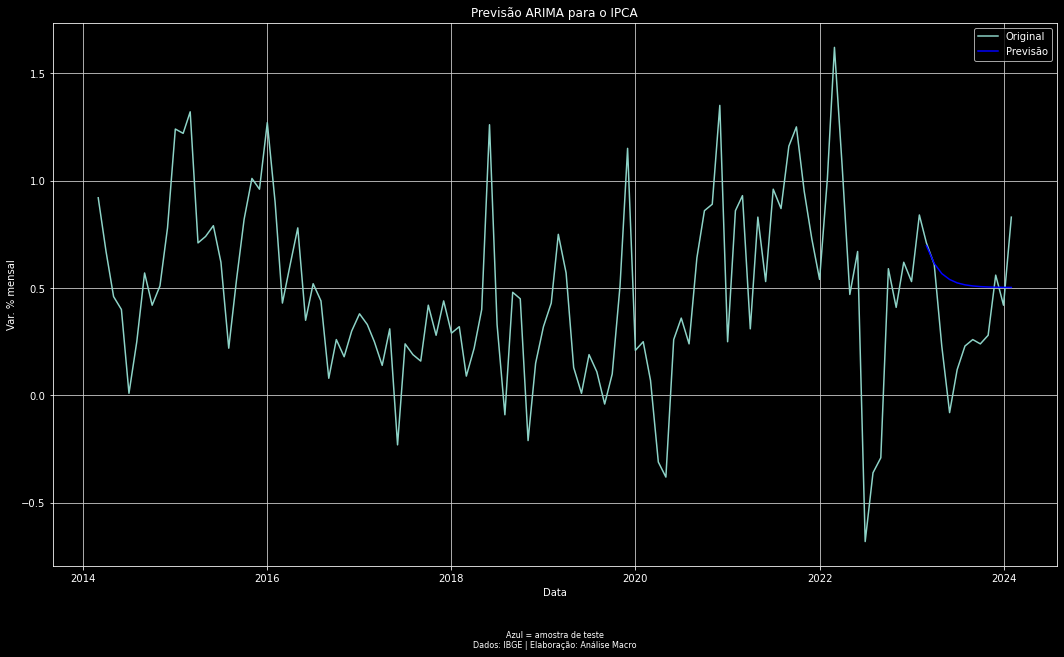

In [67]:
# Plot ARIMA
plt.figure(figsize=(18, 10))  # Definindo o tamanho da figura

# Plotando a série original
plt.plot(resultados_arima["data"], resultados_arima["y"], label="Original")

# Plotando a série de previsão
plt.plot(
    resultados_arima["data"],
    resultados_arima["previsao"],
    color="blue",
    label="Previsão",
)

# Configurando os rótulos dos eixos e título
plt.title("Previsão ARIMA para o IPCA")
plt.xlabel("Data")
plt.ylabel("Var. % mensal")

# Adicionando legenda
plt.legend()

# Configurando o formato do eixo x para exibir a cada 2 anos
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=2))

# Adicionando uma anotação
plt.annotate(
    "Azul = amostra de teste\nDados: IBGE | Elaboração: Análise Macro",
    xy=(0.5, -0.15),
    xycoords="axes fraction",
    ha="center",
    fontsize=8,
)

# Exibindo a grade no plano de fundo
plt.grid(True, color="lightgrey")

# Exibindo o gráfico
plt.show()

#### Validação de Normalidade do Resíduo

In [69]:

# Resíduos do modelo ARIMA
residuos_arima = resultados_arima.residuos_arima

# Teste de Shapiro-Wilk para normalidade
stat_shapiro, p_valor_shapiro = shapiro(residuos_arima)

print('Estatística do teste de Shapiro-Wilk:', stat_shapiro)
print('Valor p do teste de Shapiro-Wilk:', p_valor_shapiro)

# Interpretar o resultado do teste
alfa = 0.05
if p_valor_shapiro > alfa:
    print('Os resíduos parecem ser normalmente distribuídos (falha em rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeição de H0)')

Estatística do teste de Shapiro-Wilk: nan
Valor p do teste de Shapiro-Wilk: 1.0
Os resíduos parecem ser normalmente distribuídos (falha em rejeitar H0)


### Previsão SARIMA

In [70]:
# Estimar modelo SARIMA
ajuste_sarima = pmd.auto_arima(y=y_treino, seasonal=True, m=12, 
                               stepwise=True, trace=True)

# Produzir previsões
previsao_sarima = ajuste_sarima.predict(n_periods=len(y_teste))

# Gráfico de valores observados e previstos
resultados_sarima = pd.DataFrame({
    "data": y_teste.index,
    "y": y_teste,
    "previsao": previsao_sarima,
    "residuos_sarima": y_teste - previsao_sarima
})

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=90.002, Time=1.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=122.415, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=82.501, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=93.908, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=214.334, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=80.995, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=82.524, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=82.774, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=82.774, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=92.535, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=84.773, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=96.238, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.839 seconds


C:\Users\user\AppData\Local\Temp\ipykernel_18852\3791607702.py:23: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


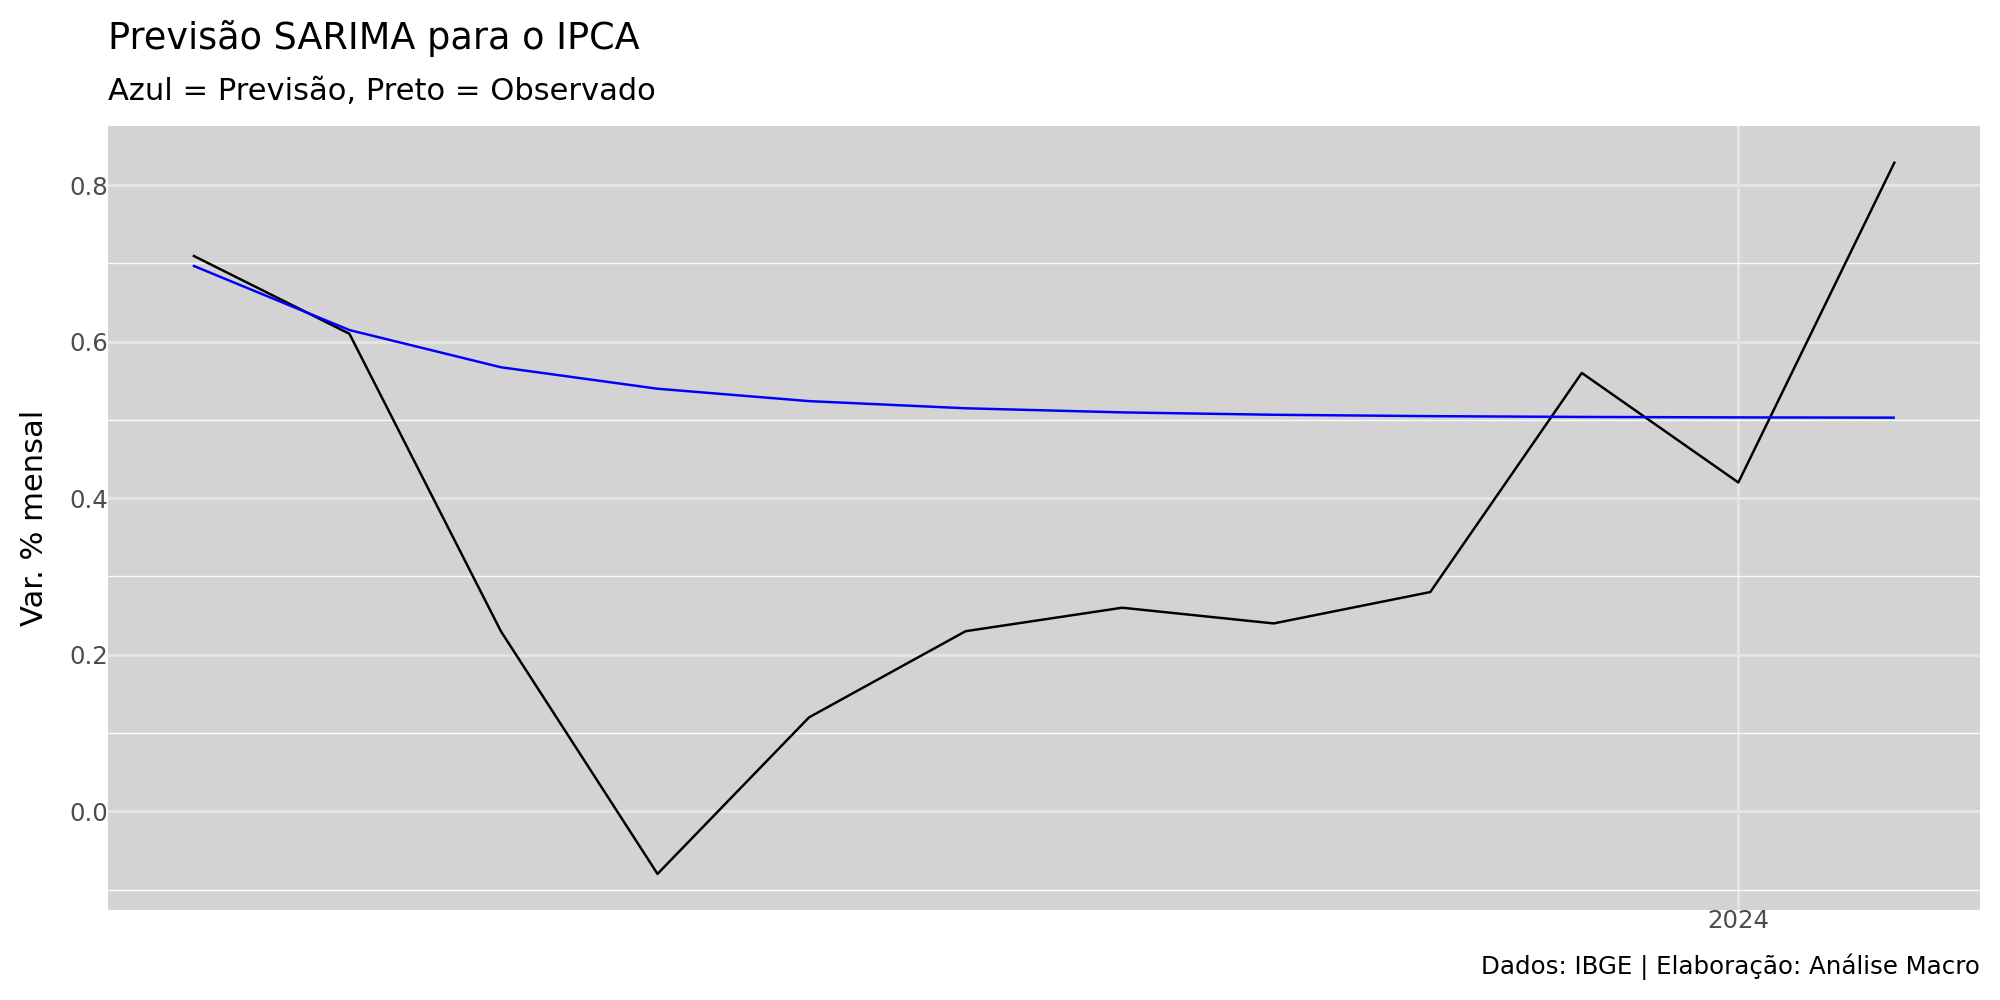

In [143]:
# Plot dos valores observados e previstos
figura_sarima = (
    p9.ggplot(resultados_sarima) +
    p9.aes(x='data', y='y') +
    p9.geom_line(color='black') +  # Linha para os valores observados
    p9.geom_line(p9.aes(y='previsao'), color='blue') +  # Linha para as previsões
    p9.scale_x_datetime(date_breaks='2 years', date_labels='%Y') +
    p9.labs(
        title='Previsão SARIMA para o IPCA',
        subtitle='Azul = Previsão, Preto = Observado',
        x='',
        y='Var. % mensal',
        caption='Dados: IBGE | Elaboração: Análise Macro'
    ) +
    p9.theme_minimal() +
    p9.theme(figure_size=(10, 5), panel_background=p9.element_rect(fill='lightgrey'))
)

print(figura_sarima)

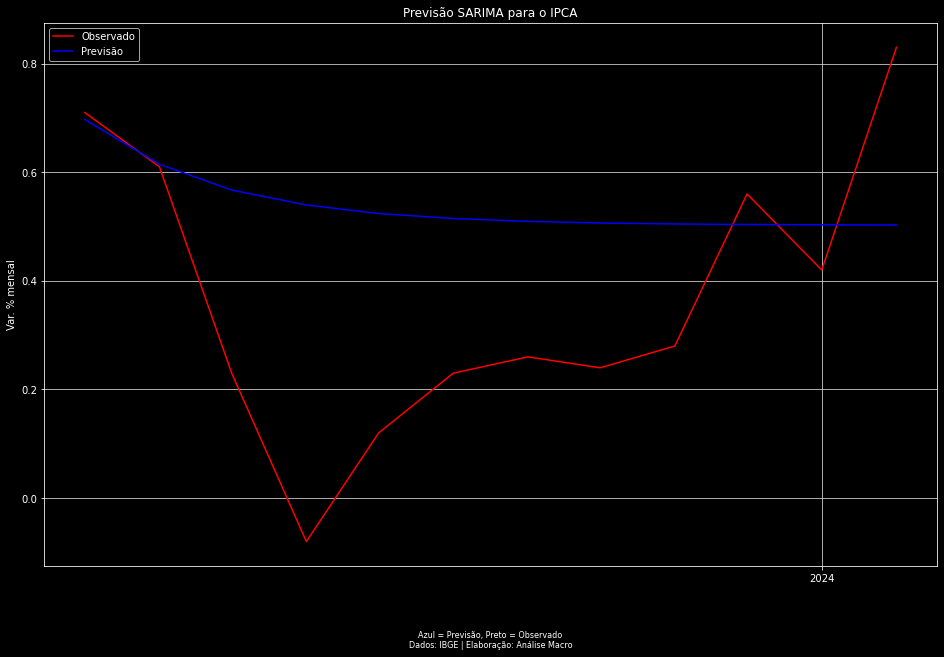

In [75]:
# Plot SARIMA
plt.figure(figsize=(16, 10))  # Definindo o tamanho da figura

# Plotando os valores observados
plt.plot(
    resultados_sarima["data"], resultados_sarima["y"], color="red", label="Observado"
)

# Plotando as previsões
plt.plot(
    resultados_sarima["data"],
    resultados_sarima["previsao"],
    color="blue",
    label="Previsão",
)

# Configurando os rótulos dos eixos e título
plt.title("Previsão SARIMA para o IPCA")
plt.xlabel("")
plt.ylabel("Var. % mensal")

# Adicionando legenda
plt.legend()

# Configurando o formato do eixo x para exibir a cada 2 anos
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=2))

# Adicionando uma anotação
plt.annotate(
    "Azul = Previsão, Preto = Observado\nDados: IBGE | Elaboração: Análise Macro",
    xy=(0.5, -0.15),
    xycoords="axes fraction",
    ha="center",
    fontsize=8,
)

# Exibindo a grade no plano de fundo
plt.grid(True, color="lightgrey")

# Exibindo o gráfico
plt.show()

#### Validação de Normalidade do Resíduo

In [76]:
# Resíduos do modelo SARIMA
residuos_sarima = resultados_sarima.residuos_sarima

# Teste de Shapiro-Wilk para normalidade
stat_shapiro, p_valor_shapiro = shapiro(residuos_sarima)

print('Estatística do teste de Shapiro-Wilk:', stat_shapiro)
print('Valor p do teste de Shapiro-Wilk:', p_valor_shapiro)

# Interpretar o resultado do teste
alfa = 0.05
if p_valor_shapiro > alfa:
    print('Os resíduos parecem ser normalmente distribuídos (falha em rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeição de H0)')

Estatística do teste de Shapiro-Wilk: 0.9738017916679382
Valor p do teste de Shapiro-Wilk: 0.9462740421295166
Os resíduos parecem ser normalmente distribuídos (falha em rejeitar H0)


### Previsão XGBoost

In [83]:
# Estimar modelo
ajuste_xgboost = xgb.XGBRegressor().fit(X = x_treino, y = y_treino)

# Produzir previsões
previsao_xgboost = ajuste_xgboost.predict(x_teste)

# Gráfico de valores observados e previstos
resultados_xgboost = pd.DataFrame(
  data = {
    "data": dados.index,
    "y": dados.ipca,
    "previsao": pd.Series(previsao_xgboost, index = previsao_arima.index),
    "residuos_xgboost": y_teste - previsao_xgboost
    },
  index = dados.index
)

C:\Users\user\AppData\Local\Temp\ipykernel_18852\3694628750.py:18: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\user\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 108 rows containing missing values.


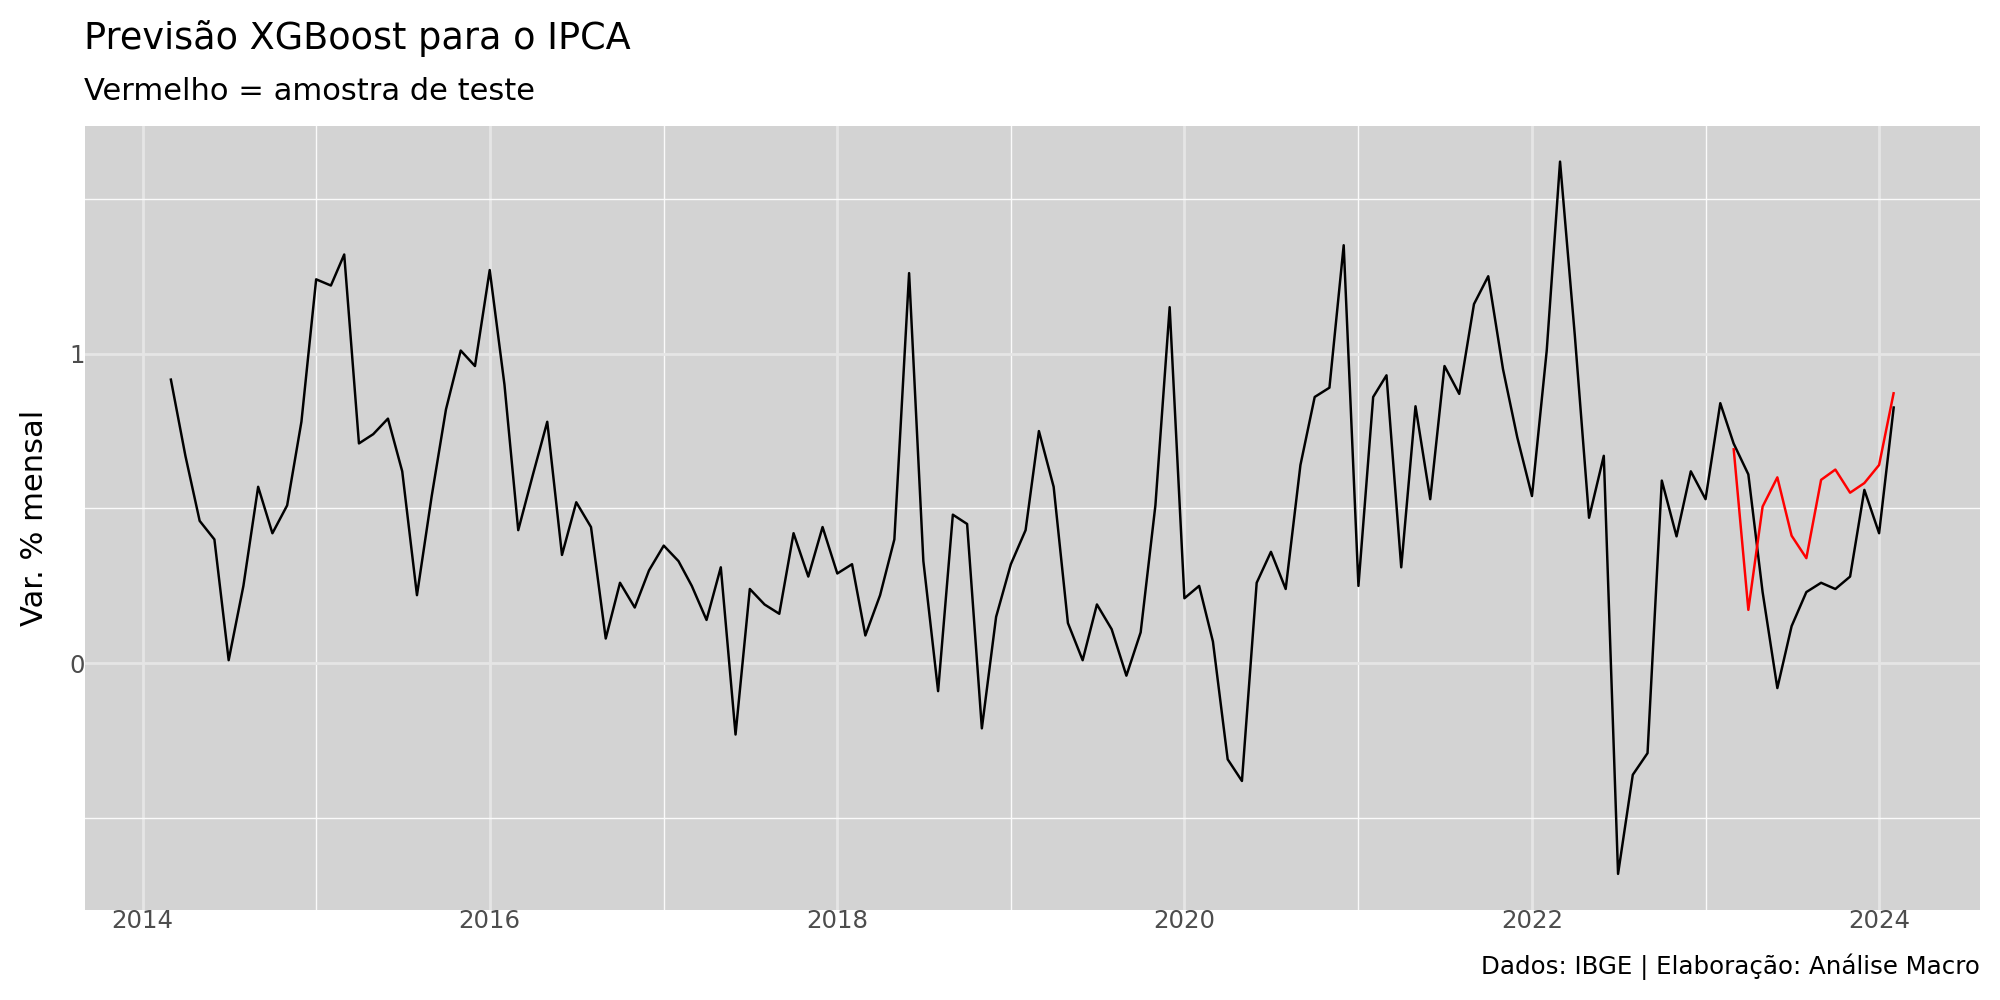

In [147]:
figura_xgboost = (
  p9.ggplot(resultados_xgboost) +
  p9.aes(x = "data", y = "y") +
  p9.geom_line() +
  p9.geom_line(mapping = p9.aes(y = "previsao"), color = "red") +
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Previsão XGBoost para o IPCA",
    subtitle = "Vermelho = amostra de teste",
    x = "",
    y = "Var. % mensal",
    caption = "Dados: IBGE | Elaboração: Análise Macro"
  ) +
  p9.theme_minimal() +
  p9.theme(figure_size=(10, 5), panel_background=p9.element_rect(fill='lightgrey'))
)

print(figura_xgboost)

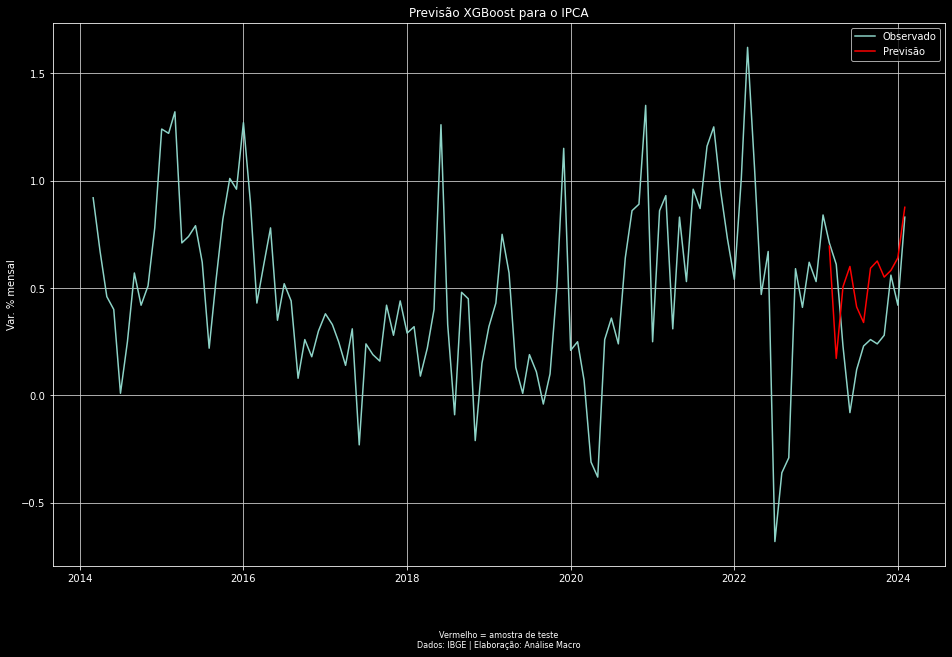

In [79]:
# Plot XGBoost
plt.figure(figsize=(16, 10))  # Definindo o tamanho da figura

# Plotando os valores observados
plt.plot(resultados_xgboost["data"], resultados_xgboost["y"], label="Observado")

# Plotando as previsões
plt.plot(
    resultados_xgboost["data"],
    resultados_xgboost["previsao"],
    color="red",
    label="Previsão",
)

# Configurando os rótulos dos eixos e título
plt.title("Previsão XGBoost para o IPCA")
plt.xlabel("")
plt.ylabel("Var. % mensal")

# Adicionando legenda
plt.legend()

# Configurando o formato do eixo x para exibir a cada 2 anos
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(base=2))

# Adicionando uma anotação
plt.annotate(
    "Vermelho = amostra de teste\nDados: IBGE | Elaboração: Análise Macro",
    xy=(0.5, -0.15),
    xycoords="axes fraction",
    ha="center",
    fontsize=8,
)

# Exibindo a grade no plano de fundo
plt.grid(True, color="lightgrey")

# Exibindo o gráfico
plt.show()

#### Validação de Normalidade do Resíduo

In [84]:
# Resíduos do modelo SGBOOST
residuos_xgboost = resultados_xgboost.residuos_xgboost

# Teste de Shapiro-Wilk para normalidade
stat_shapiro, p_valor_shapiro = shapiro(residuos_xgboost)

print('Estatística do teste de Shapiro-Wilk:', stat_shapiro)
print('Valor p do teste de Shapiro-Wilk:', p_valor_shapiro)

# Interpretar o resultado do teste
alfa = 0.05
if p_valor_shapiro > alfa:
    print('Os resíduos parecem ser normalmente distribuídos (falha em rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeição de H0)')

Estatística do teste de Shapiro-Wilk: nan
Valor p do teste de Shapiro-Wilk: 1.0
Os resíduos parecem ser normalmente distribuídos (falha em rejeitar H0)


### Comparando resultados

#### Calculando erros de previsão

In [85]:
erro_arima = y_teste - previsao_arima
erro_sarima = y_teste - previsao_sarima
erro_xgboost = y_teste - previsao_xgboost
erro_passeio_aleatorio = y_teste - y_treino.tail(12).values

In [86]:
# Calcular MAE
mae_arima = mean_absolute_error(y_teste, previsao_arima)
mae_arima = mean_absolute_error(y_teste, previsao_sarima)
mae_xgboost = mean_absolute_error(y_teste, previsao_xgboost)
mae_passeio_aleatorio = mean_absolute_error(y_teste, y_treino.tail(12).values)

# Calcular MAPE
mape_arima = np.mean(np.abs((y_teste - previsao_arima) / y_teste)) * 100
mape_sarima = np.mean(np.abs((y_teste - previsao_sarima) / y_teste)) * 100
mape_xgboost = np.mean(np.abs((y_teste - previsao_xgboost) / y_teste)) * 100
mape_passeio_aleatorio = np.mean(np.abs((y_teste - y_treino.tail(12).values) / y_teste)) * 100

# Calcular MSE
mse_arima = mean_squared_error(y_teste, previsao_arima)
mse_sarima = mean_squared_error(y_teste, previsao_sarima)
mse_xgboost = mean_squared_error(y_teste, previsao_xgboost)
mse_passeio_aleatorio = mean_squared_error(y_teste, y_treino.tail(12).values)

# Calcular RMSE
rmse_arima = np.sqrt(mse_arima)
rmse_sarima = np.sqrt(mse_sarima)
rmse_xgboost = np.sqrt(mse_xgboost)
rmse_passeio_aleatorio = np.sqrt(mse_passeio_aleatorio)

#### Calculando as métrica de Avaliação

In [87]:
# Criando DataFrame de acurácia
acuracia = pd.DataFrame({
    "Modelo": ["Arima","Sarima","XGBoost", "Passeio Aleatório Sazonal"],
    "MSE": [mse_arima, mse_sarima, mse_xgboost, mse_passeio_aleatorio],
    "RMSE": [rmse_arima, rmse_sarima, rmse_xgboost, rmse_passeio_aleatorio],
    "MAP": [mape_arima, mape_sarima, mape_xgboost, mape_passeio_aleatorio]
}).assign(
    Modelo=lambda x: pd.Categorical(
        x.Modelo,
        categories=x.sort_values(by="RMSE", ascending=False).Modelo.tolist()
    )
)

In [88]:
print("Desempenho de modelos na previsão do IPCA")
acuracia = acuracia.sort_values(by='RMSE', ascending=True)
acuracia

Desempenho de modelos na previsão do IPCA


,Modelo,MSE,RMSE,MAP
0,Arima,0.086939,0.294853,145.115067
1,Sarima,0.086939,0.294853,145.115067
2,XGBoost,0.100980,0.317773,148.578973
3,Passeio Aleatório Sazonal,0.258059,0.507995,217.453504


----